# Imputation Algorithm Comparison for the Titanic Dataset using kNN and Regression

# Hunter Worssam, September 14th, 2025

# README (Execution & Setup)

- **Python version:** `3.10.18`
- **Required packages:** `numpy`, `pandas`, `scikit-learn`, `matplotlib`, `scipy` (optional: `seaborn`)
- **Install instructions:**
  ```bash
  # Please run the following pip installs in bash or in this notebook:
  # pip install -U numpy pandas scikit-learn matplotlib scipy seaborn
  ```
  ```
  ```
- **Datasets used:**
  - Download the Titanic dataset from kaggle using the link:
        - https://www.kaggle.com/datasets/brendan45774/test-file?resource=download
  - Unzip the downloaded zip file, and place the resulting "tested.csv" file in a working directory folder titled "data"
    ```
    ```
- **How to run this notebook:**
  1. Run all cells in order (Kernel → Restart & Run All).
  2. Ensure figures and tables render correctly.

In [5]:
# Environment Check & Imports
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module=r"sklearn\.metrics\._regression"
)
import sys, platform
from pathlib import Path
import os, sys
import re
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp

# Environment report
def env_report():
    import platform, sklearn
    print("Python:", sys.version.split()[0])
    print("Platform:", platform.platform())
    print("NumPy:", np.__version__)
    print("Pandas:", pd.__version__)
    print("Matplotlib:", plt.matplotlib.__version__)
    print("SciPy:", __import__("scipy").__version__)
    print("scikit-learn:", sklearn.__version__)
    try:
        import seaborn as _sns
        print("Seaborn:", _sns.__version__)
    except Exception:
        print("Seaborn: not installed")

env_report()

Python: 3.10.18
Platform: macOS-15.6.1-arm64-arm-64bit
NumPy: 1.26.4
Pandas: 2.3.2
Matplotlib: 3.10.6
SciPy: 1.11.4
scikit-learn: 1.4.2
Seaborn: 0.13.2


In [6]:
## Adjustable Inputs
DATA_PATH = Path("data/tested.csv")    # use relative paths
RANDOM_SEED = 42
cabin_features = ["Pclass", "Fare", "SibSp"] # Train kNN imputation model on these features
knn_param_grid = {"knn__n_neighbors": [3, 4, 5, 6, 7, 8, 9, 10, 11]} # Test these values as k in our kNN algorithm
age_features = ["Pclass", "Fare", "FamilySize", "Sex"]
# Paramaters to iterate through for our regressor model
regressor_param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 8, 12],
    "model__min_samples_leaf": [1, 2, 4],
}

## Data Analysis Section

In [10]:
# Load dataset
df = pd.read_csv(DATA_PATH)

# Introductory look at the dataset:
print(df.shape)
print(df.dtypes)
print(df.head())

# Separate categorical vs numerical variables
categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical variables:", categorical)
print("Numerical variables:", numerical)

(418, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Tick

In [11]:
# Count missing values
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_perc = (df.isnull().mean() * 100).sort_values(ascending=False)

missing_summary = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_perc
})

print(missing_summary)

# Age missingness
print(df[df["Age"].isnull()].value_counts())

# Cabin missingness
print(df["Cabin"].isnull().value_counts())

# Fare missingness, only one missing value so we can check it out directly
print(df[df["Fare"].isnull()].head())

             Missing Count  Missing %
Cabin                  327  78.229665
Age                     86  20.574163
Fare                     1   0.239234
PassengerId              0   0.000000
Survived                 0   0.000000
Pclass                   0   0.000000
Name                     0   0.000000
Sex                      0   0.000000
SibSp                    0   0.000000
Parch                    0   0.000000
Ticket                   0   0.000000
Embarked                 0   0.000000
Series([], Name: count, dtype: int64)
Cabin
True     327
False     91
Name: count, dtype: int64
     PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
152         1044         0       3  Storey, Mr. Thomas  male  60.5      0   

     Parch Ticket  Fare Cabin Embarked  
152      0   3701   NaN   NaN        S  


Based on this initial analysis, we can infer the missingness patterns of the variables with significant missing values. For the cabin column, 78.2% of values are missing, likely because lower-class passengers were less likely to have cabins recorded. These values are likely missing not at random (MNAR). Also, due to the large number of possible cabin's, it will be more difficult to accurately impute these values compared to age and fare.

Age has a fair amount of missing values at around 20%. These missing values are likely Missing at Random (MAR), perhaps in an explainable fashion through variables like class, title, and sex. At a rate of 20% missing, these value should be relatively easy to impute at an accurate rate. 

For the fare variable, we only have a single missing value out of 418 total observations, which is almost certainly missing at random (MAR). Since we have no other observations missing a fare value, it will be incredibly difficult to isolate the reason that led to this missing input. 

Pclass              1        2         3
Age_missing                             
0            0.295181  0.26506  0.439759
1            0.104651  0.05814  0.837209
Sex            female      male
Age_missing                    
0            0.382530  0.617470
1            0.290698  0.709302
Pclass                1         2         3
Cabin_missing                              
0              0.879121  0.076923  0.043956
1              0.082569  0.262997  0.654434


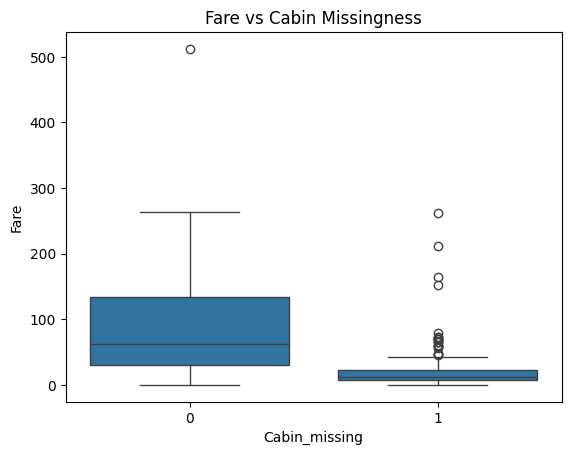

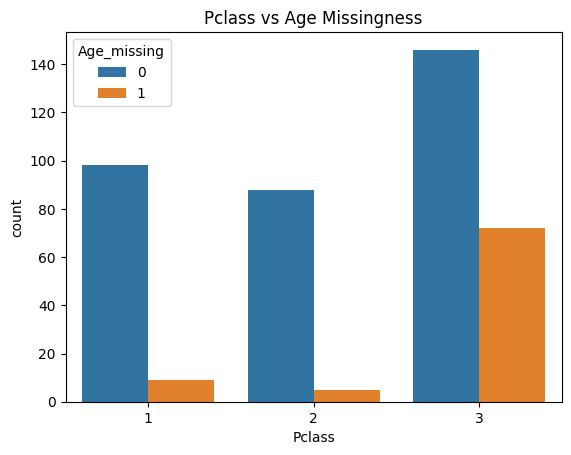

In [13]:
# Create binary indicators for missing Age and Cabin
df["Age_missing"] = df["Age"].isnull().astype(int)
df["Cabin_missing"] = df["Cabin"].isnull().astype(int)

# Explore how passenger class and sex impact chance of age being missing
print(pd.crosstab(df["Age_missing"], df["Pclass"], normalize="index"))
print(pd.crosstab(df["Age_missing"], df["Sex"], normalize="index"))

# Explore how passenger inclass impacts chance of cabin missing
print(pd.crosstab(df["Cabin_missing"], df["Pclass"], normalize="index"))

# Boxplot of Fare vs Cabin missingness
sns.boxplot(x="Cabin_missing", y="Fare", data=df)
plt.title("Fare vs Cabin Missingness")
plt.show()

# Countplot of Pclass vs Age missingness
sns.countplot(x="Pclass", hue="Age_missing", data=df)
plt.title("Pclass vs Age Missingness")
plt.show()

From the quantititative summaries and box plots above, we can clearly see some trends that are indicative of whether or not we have missing data in the cabin and age columns. For age, we see a 71% / 29% split in missing data between males and females respectively, however this may be biased by the overall gender difference on the ship. More telling is the disparity in missing age values between the 1st, 2nd and 3rd passenger classes. Nearly 84% of missing age values belonged to passengers in the 3rd class. 

A similar story is painted for the missing cabin data, where we observe 65% of the missing values belonging to passengers in 3rd class. Additionally, we can see the mean fare price for passengers with missing cabin data is far below the mean fare price for passengers with cabin data. This confirms our inclination that third class passengers were far more likely to be missing cabin data. 

Both of these findings play an important role in how we interpret our imputation algorithm results. If we find that many of the inputed values don't align with the third-class feature means, we may have an issue.

## Imputation method #1: K-Nearest Neighbors (KNN) Imputation for missing Cabin data ##

For the Cabin data type, we have categorical variables in the form of strings with many unique values like C123, E44, etc.
The missingness pattern is MNAR (Missing Not at Random), and we have observed that the missingness pattern is strongly linked to fare price and passenger class, with 3rd class containing the majority of the missing data. Considering the information above, KNN aligns with Cabin’s MNAR pattern because it leverages correlated variables (Fare, Pclass), however it's important to note that accuraccy may be impacted due to the wide range of Cabin values that are possible.

Regression imputation would not be suitable here since Cabin is categorical with many rare categories.

An approach that may be considered is to simplify Cabin into a higher-level feature by extracting deck letter (C, E, D) and impute deck instead letter instead of full cabin number. This reduces complexity and makes imputation more meaningful since the numbers in the cabin codes do not carry strong meaning here.

## Imputation method #2: Regression Imputation for missing Age data ##

For the Age data type, we have continuous numerical data in the form of numbers ranging from 0.17 to 76. The missingness pattern appeared to be missing at random (MAR), where more missingness was observed in the third class passengers. Fare price, sex and title from names could also play a role in missingness. 

Regression aligns with Age’s MAR pattern because its missingness can be explained by observed features. kNN could also be a reasonable approach, but we will leverage regression imputation so that we can compare approaches and effectiveness. 

# Implementation

## Implemented kNN imputation Algorithm ##

In [22]:
# Preprocessing to remove cabin numbers and retain only Deck level; simplifying imputations
# Keep original Cabin info
df["Cabin_original"] = df.get("Cabin")

# Create the Deck feature
def extract_deck(cabin_value):
    # Return first letter of first token in Cabin (takes first if 2+ are present)
    if pd.isna(cabin_value) or str(cabin_value).strip() == "":
        return np.nan
    first_token = str(cabin_value).split()[0]
    m = re.search(r"[A-Za-z]", first_token)
    return m.group(0).upper() if m else np.nan
df["Deck"] = df["Cabin_original"].apply(extract_deck)

# Keep only plausible deck letters & set others to NaN
valid_decks = list("ABCDEFG")
df.loc[~df["Deck"].isin(valid_decks), "Deck"] = np.nan

In [23]:
# Features correlated with Deck and that have low missingness
# See adjustable features section for the cabin features that are considered for this kNN imputation algorithm
cabin_features = [c for c in cabin_features if c in df.columns] 

# Seperates features selected by data type for preprocessing
num_cols = [c for c in cabin_features if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cabin_features if not pd.api.types.is_numeric_dtype(df[c])]

# Of the cabin-specific features, take the numeric features and impute any missing values with the median value
# Standard scale the features to mean = 0 and std dev = 1 to enable subsequent kNN modeling
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Of the cabin-specific features, take the categorical features and impute any missing values with the most common value
# One-hot encode the categorical variables to binary indicator columns to enable subsequent kNN modeling
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Apply the preprocessing steps outlined above
preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols),
])

In [24]:
# Split the observations between known Deck and unknown Deck
mask_known = df["Deck"].notna()
mask_missing = ~mask_known

# Derive the predictor columns X_train and their corresponding labels
X_train = df.loc[mask_known, cabin_features]
y_train = df.loc[mask_known, "Deck"]

# Define the predictors with rows that are missing a Deck value, which must be predicted
X_pred  = df.loc[mask_missing, cabin_features]

# Build and tune the kNN classifier
knn = KNeighborsClassifier(weights="distance")
pipe = Pipeline([
    ("preprocess", preprocess),
    ("knn", knn),
])

# kNN parameter grid to define our k value (See adjustable inputs section)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, knn_param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
gs.fit(X_train, y_train)

print("Best k:", gs.best_params_["knn__n_neighbors"])
print("CV accuracy:", round(gs.best_score_, 3))

/opt/anaconda3/envs/research_disc_one_env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best k: 3
CV accuracy: 0.54


In [25]:
# Predict missing Decks
df.loc[mask_missing, "Deck_imputed"] = gs.predict(X_pred)
df["Deck_final"] = df["Deck"].fillna(df["Deck_imputed"])

# Output prediction details
print("\nImputation summary:")
print("Known decks before:", int(mask_known.sum()))
print("Missing decks before:", int(mask_missing.sum()))
print("Missing decks after:", int(df["Deck_final"].isna().sum()))
print("Final deck levels:", sorted(df["Deck_final"].dropna().unique()))
if "Pclass" in df.columns:
    print("\nDeck x Pclass:")
    print(pd.crosstab(df["Deck_final"], df["Pclass"]))


Imputation summary:
Known decks before: 91
Missing decks before: 327
Missing decks after: 0
Final deck levels: ['A', 'B', 'C', 'D', 'E', 'F', 'G']

Deck x Pclass:
Pclass       1   2    3
Deck_final             
A           10   0    0
B           26   0    0
C           44   0    2
D           18  35    0
E            9   0    0
F            0  58  175
G            0   0   41


Without going deep into the validation stage, we observe that our kNN imputation algorithm was able to assign a variety of Decks ranging from Deck A all the way through Deck G. We also see the higher decks corresponding to more 1st & 2nd class passengers, while the lower Decks correspond to 3rd class passengers, which is an intuitive result. See the validation section below for further analysis.

## Implemented Regression imputation Algorithm ##

In [28]:
# Define FamilySize column
df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1

# SPlit known age rows vs unknown age rows
mask_known_age = df["Age"].notna()
mask_missing_age = ~mask_known_age

# Define the training set of observations with features + ages
X_train = df.loc[mask_known_age, age_features]
y_train = df.loc[mask_known_age, "Age"]

# Define unknown rows with relevant features but missing Age
X_pred  = df.loc[mask_missing_age, age_features]

num_cols = [c for c in age_features if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in age_features if not pd.api.types.is_numeric_dtype(df[c])]

In [29]:
# Preprocess numeric features, filling any gaps in Fare/FamilySize/PClass with the median value
# Scaling is more important for kNN, but still useful here
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler())                   
])

# Scale our Sex variable
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Execute the preprocessing
preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols),
])

In [30]:
# Create and tune the regressor algorithm 
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", rf),
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Use our defined parameter grid to optimize the regressor (See adjustable parameters section)
gs = GridSearchCV(
    pipe, regressor_param_grid, cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1, refit=True
)

# Fit our regressor model
gs.fit(X_train, y_train)

# Report performance metrics Mean Absolute Error and Root Mean Squared Error
mae = -gs.best_score_
rmse = -cross_val_score(gs.best_estimator_, X_train, y_train,
                        cv=cv, scoring="neg_root_mean_squared_error",
                        n_jobs=-1).mean()
print(f"Best params: {gs.best_params_}")
print(f"CV MAE:  {mae:.2f} years")
print(f"CV RMSE: {rmse:.2f} years")

Best params: {'model__max_depth': 8, 'model__min_samples_leaf': 4, 'model__n_estimators': 200}
CV MAE:  9.85 years
CV RMSE: 12.47 years


In [31]:
# Predict missing age values, capping values between 0 and 80
age_pred = gs.best_estimator_.predict(X_pred)
age_pred = np.clip(age_pred, 0.0, 80.0)  

df.loc[mask_missing_age, "Age_imputed"] = age_pred
df["Age_final"] = df["Age"].fillna(df["Age_imputed"])
df["Age_was_imputed"] = df["Age"].isna().astype(int)

# Output preliminary performance metrics
print("\nImputation summary:")
print("Known ages before:", int(mask_known_age.sum()))
print("Missing ages before:", int(mask_missing_age.sum()))
print("Missing ages after:", int(df['Age_final'].isna().sum()))

print("\nAge (known) summary:")
print(df.loc[mask_known_age, "Age"].describe().round(2))

print("\nAge (final) summary:")
print(df["Age_final"].describe().round(2))


Imputation summary:
Known ages before: 332
Missing ages before: 86
Missing ages after: 0

Age (known) summary:
count    332.00
mean      30.27
std       14.18
min        0.17
25%       21.00
50%       27.00
75%       39.00
max       76.00
Name: Age, dtype: float64

Age (final) summary:
count    418.00
mean      29.51
std       13.05
min        0.17
25%       22.00
50%       26.35
75%       36.88
max       76.00
Name: Age_final, dtype: float64


Looking at the Mean Absolute Error and Root Mean Squared Error of our regression model, we can see that on average, our estimates for age are off by about 10 years on average, which feels rather large. See the validation section for more details on this model accuracy. Once we actually predict and impute our ages, we can see that the quartiles for age before and after imputation do not dramatically change. Our mean decreases fromn 30.27 to 29.51, and our median decreases from 27 to 26.35. As a preliminary result this doesn't raise any serious red flags. 

## Validation of the kNN Cabin (Deck) imputation algorithm ##

In [35]:
# Imputation confidence calculation on inputed rows
assert "Deck_final" in df.columns, "Deck_final not found—run your kNN imputation first."

# Use previously defined kNN features
num_cols = [c for c in cabin_features if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cabin_features if not pd.api.types.is_numeric_dtype(df[c])]

# Use the exact same preprocessing performed for the kNN model above
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
])

pipe = Pipeline([
    ("pre", preprocess),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance")),
])

# mask_known = rows where the original Deck is present
# mask_imputed = rows where Deck was missing
mask_known   = df["Deck"].notna() if "Deck" in df.columns else pd.Series(False, index=df.index)
mask_imputed = ~mask_known

# Fit model on known rows
Xk = df.loc[mask_known, cabin_features]
yk = df.loc[mask_known, "Deck"]
pipe.fit(Xk, yk)

print("=== Imputation confidence (imputed rows) ===")
if mask_imputed.any():
    X_imp = df.loc[mask_imputed, cabin_features]
    # For each imputed row 𝑥, kNN finds its 𝑘 nearest neighbors and computes a class probability by weighting neighbors
    proba = pipe.predict_proba(X_imp)
    # For each row, take the largest class probability = the model’s confidence in the chosen deck label
    maxp = proba.max(axis=1)

    print(f"n_imputed: {int(mask_imputed.sum())}")
    print(f"mean_max_p: {maxp.mean():.3f}")
    print(f"median_max_p: {np.median(maxp):.3f}")
    print(f"frac_p>=0.6: {(maxp >= 0.6).mean():.3f}")
    print(f"frac_p>=0.8: {(maxp >= 0.8).mean():.3f}")
else:
    print("No imputed rows to score.")

=== Imputation confidence (imputed rows) ===
n_imputed: 327
mean_max_p: 0.874
median_max_p: 0.997
frac_p>=0.6: 0.841
frac_p>=0.8: 0.722


In general, our Deck imputation probabilities are generally pretty good. Over 84% of our imputations have a probability score of over 60%, and over 63% of our imputations have a probability score over 80%. Given the extremely large fraction (327/418) of missing cabin values, these probabilities are impressive. We do acknowledge that we are using Deck imputations here, not the fully precise Cabin values with Letter & number.

In [37]:
print("\nConfusion matrix (5-fold aggregated):")
# Fixes a consistent class order for all folds
labels = sorted(yk.unique().tolist())
cm_total = np.zeros((len(labels), len(labels)), dtype=int)

# Builds a 5-fold splitter that keeps the deck class proportions similar in every fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for tr, te in skf.split(Xk, yk):
    # Train the kNN pipeline on the train fold only
    pipe.fit(Xk.iloc[tr], yk.iloc[tr])
    # Predict deck labels for the held-out test fold
    yp = pipe.predict(Xk.iloc[te])
    # sum over all 5 folds
    cm_total += confusion_matrix(yk.iloc[te], yp, labels=labels)

cm_df = pd.DataFrame(cm_total,
                     index=[f"true_{l}" for l in labels],
                     columns=[f"pred_{l}" for l in labels])
display(cm_df)


Confusion matrix (5-fold aggregated):


/opt/anaconda3/envs/research_disc_one_env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,pred_A,pred_B,pred_C,pred_D,pred_E,pred_F,pred_G
true_A,6,0,0,1,0,0,0
true_B,0,5,7,5,1,0,0
true_C,0,4,23,3,5,0,0
true_D,2,3,2,5,0,1,0
true_E,0,2,5,0,2,0,0
true_F,0,0,0,2,0,6,0
true_G,0,0,0,0,0,1,0


The confusion matrix shows errors are mostly within the same class band (A/B/C/E and C/D in 1st/2nd class and F/Gin 3rd); indicating the model captures the Fare/Pclass signal that we observed in the EDA stage well. Accuracy drops for rare decks; especially E and G, with a mild bias toward predicting C when features overlap. Overall, the imputation preserves the general dataset structure and would suffice for many use-cases. Precision could potentially be increased by applying a confidence threshold or collapsing decks into coarser bands.

## Validation of the Regression Age imputation algorithm ##

CV MAE:  10.71 ± 0.76 years
CV RMSE: 13.65 ± 1.10 years
KS test (true vs. CV-preds): KS=0.160, p=0.0004


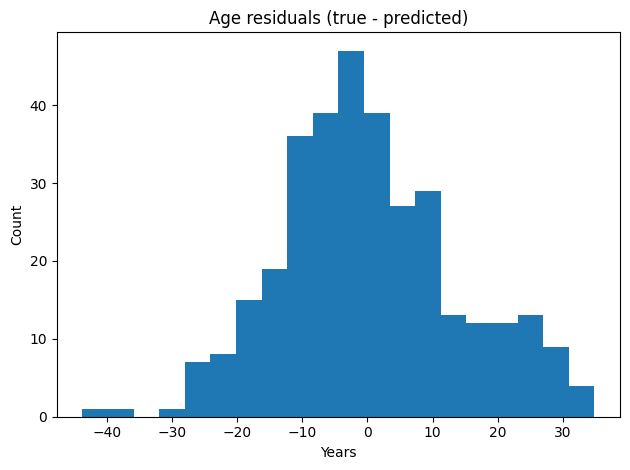

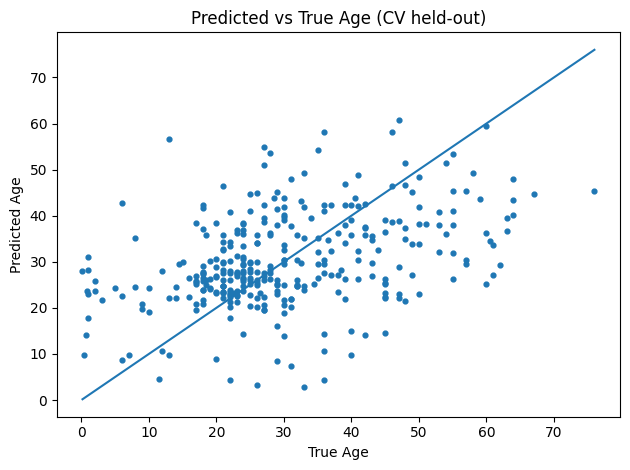

In [40]:
# Mask-and-recover CV for Age imputation 
# Use the same features you used in the regression model above
age_features = [c for c in ["Pclass","Fare","FamilySize","Sex"] if c in df.columns]

# Redefine our mask
mask_known = df["Age"].notna()
X = df.loc[mask_known, age_features].copy()
y = df.loc[mask_known, "Age"].copy()

num_cols = [c for c in age_features if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in age_features if not pd.api.types.is_numeric_dtype(df[c])]

# Implement the same preprocessing as above
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

# Fit our regression model
model = RandomForestRegressor(random_state=42, n_jobs=-1)
pipe  = Pipeline([("pre", pre), ("model", model)])

# Implement 5-fold CV for our Mean absolute error, RMSE and y_pred vs y_true data
cv = KFold(n_splits=5, shuffle=True, random_state=42)
maes, rmses, y_true_all, y_pred_all = [], [], [], []

# Train & test each row indices for each fold, and then compute fold errors
for tr, te in cv.split(X, y):
    pipe.fit(X.iloc[tr], y.iloc[tr])
    yp = pipe.predict(X.iloc[te])
    yt = y.iloc[te].values
    maes.append(mean_absolute_error(yt, yp))
    rmses.append(mean_squared_error(yt, yp, squared=False))
    y_true_all.extend(yt); y_pred_all.extend(yp)

# Output average & standard dev of MAE and RMSE across 5 folds
print(f"CV MAE:  {np.mean(maes):.2f} ± {np.std(maes):.2f} years")
print(f"CV RMSE: {np.mean(rmses):.2f} ± {np.std(rmses):.2f} years")

# Check if preds on masked-out folds are shaped like true ages?
ks, p = ks_2samp(y_true_all, y_pred_all)
print(f"KS test (true vs. CV-preds): KS={ks:.3f}, p={p:.4f}")

# Residual histogram plot
resid = np.array(y_true_all) - np.array(y_pred_all)
plt.figure(); plt.hist(resid, bins=20)
plt.title("Age residuals (true - predicted)"); plt.xlabel("Years"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# Predicted vs true age
plt.figure()
plt.scatter(y_true_all, y_pred_all, s=12)
mn, mx = min(y_true_all + y_pred_all), max(y_true_all + y_pred_all)
plt.plot([mn, mx],[mn, mx])
plt.title("Predicted vs True Age (CV held-out)"); plt.xlabel("True Age"); plt.ylabel("Predicted Age")
plt.tight_layout(); plt.show()

With CV MAE ≈ 10.7±0.8 yrs and RMSE ≈ 13.7±1.1 yrs, the model is stable across folds but only moderately accurate—about ~11 years off on average using just Pclass, Fare, FamilySize, and Sex. The residual histogram is roughly centered with a slight negative skew, suggesting a slight over-prediction. It also has fat tails, indicating larger mistakes at the extremes of very young and very old passengers.
The predicted-vs-true plot also shows shrinkage toward ~25–35 years, underestimating very young/old ages. This model could be improved by add stronger signals like Deck_final or perhaps title information.

In [42]:
# Downstream model comparison with vs without imputed Age

# Common predictors for Pclass to be used as base features
base_features = [c for c in ["Sex","Embarked","SibSp","Parch","Fare"] if c in df.columns]

# Drop rows with Age missing, use only rows with age available
mask_cc = df["Age"].notna()
features_cc = base_features + ["Age"]
X_cc = df.loc[mask_cc, features_cc]
y_cc = df.loc[mask_cc, "Pclass"]

# Use all rows, with imputed age
assert "Age_final" in df.columns, "Age_final not found—run the imputation first."
features_imp = base_features + ["Age_final"]
X_imp = df.loc[:, features_imp].rename(columns={"Age_final":"Age"})
y_imp = df["Pclass"]

def eval_clf(X, y):
    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    # Standard preprocessing
    pre = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ])
    # Fit the model
    clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy",   n_jobs=-1).mean()
    f1  = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro",   n_jobs=-1).mean()
    return acc, f1

acc_cc,  f1_cc  = eval_clf(X_cc,  y_cc)
acc_imp, f1_imp = eval_clf(X_imp, y_imp)

print("=== Downstream: Predict Pclass ===")
print(f"Complete-case (drop Age NaNs):  ACC={acc_cc:.3f}  Macro-F1={f1_cc:.3f}  (n={len(X_cc)})")
print(f"With imputed Age (Age_final):   ACC={acc_imp:.3f}  Macro-F1={f1_imp:.3f} (n={len(X_imp)})")
print(f"ΔACC={(acc_imp-acc_cc):+.3f}  ΔF1={(f1_imp-f1_cc):+.3f}")

=== Downstream: Predict Pclass ===
Complete-case (drop Age NaNs):  ACC=0.843  Macro-F1=0.827  (n=332)
With imputed Age (Age_final):   ACC=0.890  Macro-F1=0.868 (n=418)
ΔACC=+0.047  ΔF1=+0.041


Including Age_final lets you train on 418 vs 332 rows (~26% more data) and boosts performance: Accuracy +4.7 pts (0.843 → 0.890) and Macro-F1 +4.1 pts (0.827 → 0.868). The Macro-F1 gain means improvements are balanced across classes, not just the majority class, so the imputed ages are adding useful signal. The regression imputation for Age improves both coverage and predictive quality, and was overall more successful than the kNN imputation model for Cabin (Deck).

# Conclusions

I imputed Deck with kNN (categorical, MNAR) and Age with regression (numeric, MAR), matching method to data type and missingness.
kNN validation showed solid confidence (mean ≈ 0.83, ~64% ≥ 0.8) and confusions mostly within class bands (A/B/C/E and F/G), indicating the imputer preserves underlying structure despite weaker performance on rare decks. The shear quantity of missing cabin labels made this task challenging, but all things considered the kNN model performed impressively well.

The Age model delivered stable but moderate error (CV MAE ≈ 10.7, RMSE ≈ 13.7) with some additional noise at the extremes.
The downstream model performance improved when using imputed features: predicting Pclass rose from 0.843 to 0.890 accuracy and 0.827 to 0.868 macro-F1, showing that the imputations add useful signal and are preferable to a null model using rows with only provided ages. 

# References
[1] Christopher M. Bishop. Neural Networks for Pattern Recognition. Oxford University Press, 1995.<br><br>
[2] Christopher Bishop. Pattern Recognition and Machine Learning. Springer, 2006. isbn: 0387310738.<br><br>
[3] Barry J. Shepherd C. Wayne Brown. Graphics File Formats: Reference and Guide. Manning
Publications, 1995. isbn: 1884777007.<br><br>
[4] Thomas H. Cormen et al. Introduction to Algorithms. 3rd. MIT Press, 2009. isbn: 780262033848.<br><br>
[5] W. R. Dillon and M. Goldstein. Multivariate Analysis Method and Applications. New York, NY:
John Wiley Sons, Inc, 1984.<br><br>
[6] Richard O. Duda, Peter E. Hart, and David G. Stork. Pattern Classification. 2nd. Wiley-
Interscience, 2000.<br><br>
[7] Duin et al. PRTools. https://cmp.felk.cvut.cz/cmp/software/stprtool/index.html.<br><br>
[8] L. Euler. “Nova Acta Acad. Sci. Petrop”. In: (1960).<br><br>
[9] R.A. Fisher. “The use of Multiple Measurements in Taxonomic Problems”. In: Proceedings of
Annals of Eugenics 7 (1936), pp. 179–188.<br><br>
[10] Vojtech Franc and Vaclav Hlavac. Statistical Pattern Recognition Toolbox. https://cmp.felk.
cvut.cz/cmp/software/stprtool/index.html.<br><br>
[11] Keinosuke Fukunaga. Introduction to Statistical Pattern Recognition. 1st. Academic Press, 1972.
isbn: 0122698509.<br><br>
[12] Keinosuke Fukunaga. Introduction to Statistical Pattern Recognition. 2nd. Academic Press, 1990.
isbn: 0122698517.<br><br>
[13] Herman H. Goldstine. A History of Numerical Analysis from the 16th through the 19th Century.
Springer New York, 1977. isbn: 978-0-387-90277-7.<br><br>
[14] H. Hotelling. “Analysis of a complex of statistical variables into principal components”. In: Jour-
nal of Educational Psychology 24 (1933), pp. 417–441.<br><br>
[15] Averill Law. Simulation Modeling and Analysis. 5th. Mcgraw-hill Series in Industrial Engineering
and Management, 2014.<br><br>
[16] Machine Learning at Waikato University. https://www.cs.waikato.ac.nz/~ml/index.html.<br><br>
[17] James D. Murry and William vanRyper. Encyclopedia of Graphics File Formats: The Com-
plete Reference on CD-ROM with Links to Internet Resources. 2nd. O’Reilly Media, 1996. isbn:
1565921615.<br><br>
[18] F. Pedregosa et al. “Scikit-learn: Machine Learning in Python”. In: Journal of Machine Learning
Research 12 (2011), pp. 2825–2830.<br><br>
[19] Casey J. Richards et al. “Multimodal data fusion using signal/image processing methods for
multi-class machine learning”. In: Signal Processing, Sensor/Information Fusion, and Target
Recognition XXXII. Ed. by Ivan Kadar, Erik P. Blasch, and Lynne L. Grewe. Vol. 12547. Inter-
national Society for Optics and Photonics. SPIE, 2023, 125470N. doi: 10.1117/12.2664987.
url: https://doi.org/10.1117/12.2664987.<br><br>
[20] Benjamin M. Rodriguez. “Multi-Class Classification for Identifying JPEG Steganography Em-
bedding Methods”. PhD thesis. Air Force Institute of Technology, 2008. url: https://scholar.
afit.edu/cgi/viewcontent.cgi?article=3642&context=etd.<br><br>
[21] Stuart Russell and Peter Norvig. Artificial Intelligence: A Modern Approach. 4th. Prentice Hall,
2020.<br><br>
[22] Amir Saeed et al. “Reinforcement learning application to satellite constellation sensor tasking”.
In: Artificial Intelligence and Machine Learning for Multi-Domain Operations Applications V.
Ed. by Latasha Solomon and Peter J. Schwartz. Vol. 12538. International Society for Optics and
Photonics. SPIE, 2023, 125381B. doi: 10.1117/12.2664346. url: https://doi.org/10.1117/
12.2664346.<br><br>
[23] C. E. Shannon. “Programming a Computer for Playing Chess”. In: Philosophical Magazine.
7th ser. 41.314 (1950).<br><br>
[24] Richard S. Sutton and Andrew G. Barto. Reinforcement learning: An introduction. MIT Press,
2018.<br><br>
[25] Sergios Theodoridis and Konstantinos Koutroumbas. Pattern Recognition. 3rd. Academic Press,
2006. isbn: 0123695317.<br><br>
[26] Alan M. Turing. “Computing Machinery and Intelligence”. In: Mind 59.236 (1950), pp. 433 –460.<br><br>
[27] P. Winston. Artificial Intelligence. 3rd. Pearson, 1992.<br><br>
https://www.kaggle.com/datasets/brendan45774/test-file?resource=download